In [17]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.clusterEDA import *
from code.fc import *

from sklearn.preprocessing import scale


import plotly.plotly as py
import plotly.graph_objs as go
from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_pickle('data/df_id.pkl')

In [10]:
pub = df.degree.value_counts()
one = df[df.cluster==1].degree.value_counts()

In [11]:
b = pd.DataFrame([pub,one], index = ['public',"cluster one"])

In [12]:
b = b.apply(lambda x: x/x.sum(), axis =1)

[autoreload of code.clusterEDA failed: Traceback (most recent call last):
  File "/Users/yleng/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "code/clusterEDA.py", line 51
    def one_pub_bar(df,cluster_id, variable, size = ):
                                                    ^
SyntaxError: invalid syntax
]


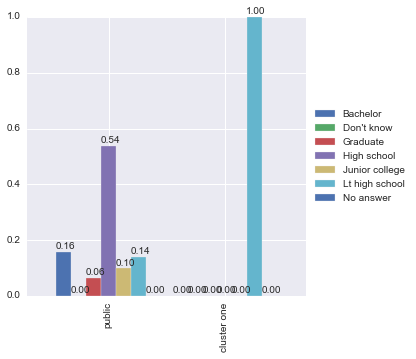

In [16]:
ax = b.plot(kind = 'bar',width = 0.9,figsize = (5,5))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+0.01,'%1.2f'%(height))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
b

In [ ]:
from ggplot import *

In [ ]:
bt = b.T

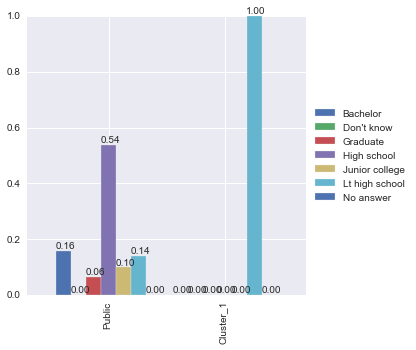

In [20]:
one_pub_bar(df,1,'degree')